In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
weather = pd.read_csv(r'C:\Users\김상휘\Desktop\dacon\weather_v1.csv')
target = pd.read_csv(r'C:\Users\김상휘\Desktop\dacon\target_v1.csv')

###### 데이터 결측치 확인

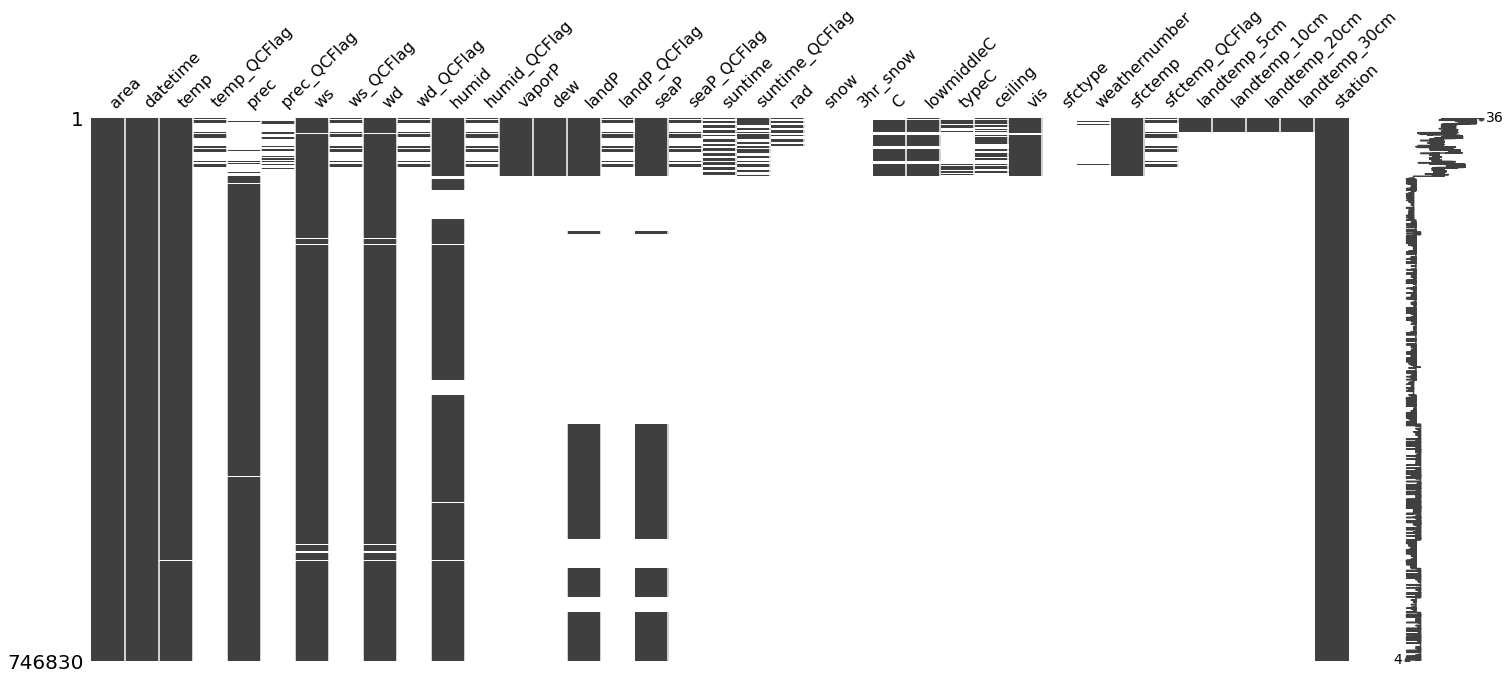

In [3]:
import missingno as msno
msno.matrix(weather)

##### smp, supply, weather 간의 상관관계 확인

In [3]:
weather['date'] = weather['datetime'].apply(lambda x: x[:10])

In [4]:
weather_mean = weather.groupby('date').mean().reset_index(drop = True)

In [5]:
# target과 weather의 상관관계 파악
pd.concat([target,weather_mean],axis=1).corr().loc['smp_max':'supply','area':].abs().mean().sort_values(ascending = False).head(10)

landtemp_30cm    0.318214
landtemp_5cm     0.294053
landtemp_10cm    0.291533
landtemp_20cm    0.287504
temp             0.283490
sfctemp          0.276526
dew              0.262873
vaporP           0.248143
snow             0.235689
3hr_snow         0.215909
dtype: float64

##### smp, supply 의 시계열적 특성을 이용하기 위해 datetime 속성으로 변환

In [6]:
target['date'] = pd.to_datetime(target['date'])

In [7]:
target['year'] = target['date'].dt.year
target['month'] = target['date'].dt.month
target['day'] = target['date'].dt.day
target['dayofweek'] = target['date'].dt.dayofweek

##### 공공데이터 공휴일 API -> 공휴일 특성  추가

In [8]:
import requests
import xmltodict
import json

In [10]:
key = "MoWjfkWS0aa1pVz1%2B38Ec1KusKDhrxZx4sU3I0RdIQvIcMjNUa6O454%2BtRJLpmA2Mi2FeJ1SjTyBGlNxLM6Mjw%3D%3D"

holidays = pd.DataFrame(columns=['date','name'])
date_list = []
name_list = []

for year_ in ['2018','2019','2020']:    
    for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
        url = "http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getHoliDeInfo?solYear="+year_+"&solMonth="+month+"&ServiceKey="+key
        content = requests.get(url).content

        #xml을 json으로 변환
        dict = xmltodict.parse(content)

        #json 파일로 변환
        jsonString = json.dumps(dict['response']['body'], ensure_ascii = False) #'아스키코드가 아니다' 라는 파라미터 추가

        #파이썬에서 다룰수 있게 변환
        jsonObj = json.loads(jsonString)

        if jsonObj['items'] == None:
            continue

        holi_dict = jsonObj['items']['item']

        if type(holi_dict) == list: 
            for i in range(len(holi_dict)):
                date_list.append(holi_dict[i]['locdate'])
                name_list.append(holi_dict[i]['dateName'])
        else:
            date_list.append(holi_dict['locdate'])
            name_list.append(holi_dict['dateName'])

date_arr = np.array(date_list)
name_arr = np.array(name_list)

holidays['date'] = date_arr
holidays['name'] = name_arr
holidays['date'] = pd.to_datetime(holidays['date'])

In [11]:
# 데이터 합치기
target = pd.merge(target,holidays,on='date',how='left')

In [12]:
# 열 이름 변경
names = target.columns.tolist()
names[names.index('name')] = 'holidays'
target.columns = names

In [13]:
# 공휴일 특성 이진수로 변경
target['holidays'].fillna(0, inplace = True)

for i in range(len(target)):
    if target['holidays'][i] !=0:
        target['holidays'][i] = 1

# 타입 변경
target['holidays'] = target['holidays'].astype(int)

#### 유가 데이터 수집

In [14]:
import time
from datetime import datetime

def get_oil_price(code):
    delay = 0.01
    page = 1
    result = []
    start_date = '2018.02.01'
    end_date = '2020.01.31'
    start_time = datetime.now()
    
    # 수집
    print('[{}] 데이터 수집을 시작합니다. (code: {})'.format(start_time.strftime('%Y/%m/%d %H:%M:%S'), code))
    while(True):
        url = 'https://finance.naver.com/marketindex/worldDailyQuote.nhn?marketindexCd={}&fdtc=2&page={}'.format(code, page)
        data = pd.read_html(url)[0].dropna()
        if page != 1:
            try:
                if '2018.02.01' in data.iloc[:,0].values:
                    data = data.loc[:data.iloc[:,0].values.tolist().index(start_date),]
                    result.append(data)
                    break
            except:
                break
        result.append(data)
        page += 1
        time.sleep(delay)
    
    # 가공
    oil_price = pd.concat(result).reset_index(drop=True)
    oil_price.columns = ['date', 'price', '전일대비', '등락율']
    oil_price = oil_price.loc[oil_price['date'].tolist().index(end_date):,]
    oil_price['date'] = oil_price['date'].apply(lambda x: datetime.strptime(x, '%Y.%m.%d'))
    oil_price = oil_price[['date', 'price']]
    oil_price.insert(0, 'code', code)
    oil_price = oil_price[::-1].reset_index(drop=True)
    
    end_time = datetime.now()
    print('[{}] 데이터 수집을 종료합니다. (code: {}, 수집시간: {}초, 데이터수: {:,}개)'.format(end_time.strftime('%Y/%m/%d %H:%M:%S'), code, (end_time-start_time).seconds, len(oil_price)))
    return oil_price

In [15]:
oil_price_du = get_oil_price('OIL_DU')
oil_price_wti = get_oil_price('OIL_CL')
oil_price_brent = get_oil_price('OIL_BRT')

[2020/05/24 22:40:31] 데이터 수집을 시작합니다. (code: OIL_DU)
[2020/05/24 22:40:59] 데이터 수집을 종료합니다. (code: OIL_DU, 수집시간: 27초, 데이터수: 503개)
[2020/05/24 22:40:59] 데이터 수집을 시작합니다. (code: OIL_CL)
[2020/05/24 22:41:26] 데이터 수집을 종료합니다. (code: OIL_CL, 수집시간: 27초, 데이터수: 504개)
[2020/05/24 22:41:26] 데이터 수집을 시작합니다. (code: OIL_BRT)
[2020/05/24 22:41:50] 데이터 수집을 종료합니다. (code: OIL_BRT, 수집시간: 23초, 데이터수: 513개)


In [16]:
oil_list = []
oil_list.append(oil_price_du)
oil_list.append(oil_price_wti)
oil_list.append(oil_price_brent)
code_list = ['OIL_DU','OIL_CL','OIL_BRT']

for i, code in enumerate(code_list):
    oil_list[i].drop(['code'],axis=1,inplace=True)
    oil_list[i].columns = ['date',str(code)+'_price']

In [17]:
start = '2018-02-01'
end = '2020-01-31'
daily_price_oil = pd.DataFrame(columns = ['date'])
date_range = pd.date_range(start,end,freq = 'D')
daily_price_oil['date'] = date_range

In [18]:
for d in oil_list:
    daily_price_oil = daily_price_oil.merge(d,how='outer')

In [19]:
daily_price_oil['mean'] = round(daily_price_oil.mean(axis=1),2)
daily_price_oil = daily_price_oil.loc[:,['date','mean']]
daily_price_oil.columns = ['date','oil_price']

In [20]:
# 총 세번 진행
daily_price_oil['oil_price'][daily_price_oil['oil_price'].isna()] = daily_price_oil.shift(-1)['oil_price'][daily_price_oil['oil_price'].isna()]
daily_price_oil['oil_price'][daily_price_oil['oil_price'].isna()] = daily_price_oil.shift(-1)['oil_price'][daily_price_oil['oil_price'].isna()]
daily_price_oil['oil_price'][daily_price_oil['oil_price'].isna()] = daily_price_oil.shift(-1)['oil_price'][daily_price_oil['oil_price'].isna()]

In [21]:
target['oil_price'] = daily_price_oil['oil_price']

In [22]:
target['oil_price'].isnull().sum()

0

##### weather 데이터 전처리 // 
- ASOS 지역 기온만 사용 (제주, 고산, 성산, 서귀포)

- 기온은 지역별 기온의 중앙값 사용

- 선정된 기온에서 그 날의 최소, 최대, 평균기온 찾아 target에 추가

- ASOS 지역 기온만 사용 (제주, 고산, 성산, 서귀포)

In [23]:
weather = weather[weather['station'] == 'ASOS']

- 기온은 지역별 기온의 중앙값 사용

In [24]:
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather = weather.loc[:,'area':'temp']

In [25]:
# 필요없는 'area'열 삭제, 열 이름에 area 추가
# area별로 새로운 list에 묶어서 간단히 해결

weather_list = []
for area in weather['area'].unique():
    weather_list.append(weather[weather['area']==area].copy())

for i, area in enumerate(weather['area'].unique()):
    weather_list[i].drop(['area'],axis=1,inplace=True)
    weather_list[i].columns = ['datetime',str(area)+'_temp']

In [26]:
# 각 지역의 시간별 기온을 합쳐서 중앙값으로 만든 새로운 데이터 프레임

start = '2018-02-01'
end = '2020-01-31'
hourly_temperature = pd.DataFrame(columns = ['datetime'])
date_range = pd.date_range(start,end,freq = 'H')
hourly_temperature['datetime'] = date_range

In [27]:
# 시간별 온도 데이터 중앙값(같은 데이터 프레임에 병합해서 구함)
for d in weather_list:
    hourly_temperature = hourly_temperature.merge(d,how='outer')
hourly_temperature['median'] = hourly_temperature.median(axis=1)
hourly_temperature = hourly_temperature.loc[:,['datetime','median']]
hourly_temperature.columns = ['date','temperature']

In [28]:
# 결측치 1시간 후의 온도로 처리
hourly_temperature['temperature'][hourly_temperature['temperature'].isna()] = hourly_temperature.shift(-1)['temperature'][hourly_temperature['temperature'].isna()]

In [29]:
hourly_temperature['temperature'].isnull().sum()

0

- 선정된 기온에서 그 날의 최소, 최대, 평균기온 찾아 target에 추가

In [30]:
start = '2018-02-01'
end = '2020-01-31'
daily_temperature = pd.DataFrame(columns = ['date'])
date_range = pd.date_range(start, end, freq='D')
daily_temperature['date'] = date_range

In [31]:
# 해당 날짜의 최대, 최소값을 찾기 위해 24시간을 한 행으로 나타냄
for d in range(daily_temperature.shape[0]):
    for h in range(24):
        daily_temperature.loc[d, 'temp_h'+str(h)] = hourly_temperature['temperature'][d*24:d*24+24][d*24+h]

In [32]:
daily_temperature['temp_max'] = daily_temperature.loc[:,'temp_h0':].max(axis=1)
daily_temperature['temp_min'] = daily_temperature.loc[:,'temp_h0':].min(axis=1)
daily_temperature['temp_mean'] = daily_temperature.loc[:,'temp_h0':].mean(axis=1)

In [33]:
# target값에 추가
target['temp_max'] = daily_temperature['temp_max']
target['temp_min'] =daily_temperature['temp_min']
target['temp_mean'] = daily_temperature['temp_mean']

# 모델 학습 및 검증

#### supply와 날씨데이터 예측

In [34]:
def create_model(d_train,d_val):
    params = {
        'metrics' : 'mae',
        'seed' : 7777
    }
    
    model = lgb.train(params, d_train, 1000, d_val, verbose_eval = 1000, early_stopping_rounds=100)
    
    plt.rcParams['figure.figsize'] = [6,4]
    plt.plot(y_val, '.-', label='y_val')
    plt.plot(model.predict(x_val),'.-', label='y_pred')
    plt.title(str(future)+'days later')
    plt.legend()
    plt.show()
    
    return model

In [35]:
def trans(dataset, start_index, end_index, past, future, x_columns, y_columns):
    dataset.index = range(dataset.shape[0])
    data = []
    labels = []
    
    start_index = start_index+past
    
    if end_index is None:
        end_index = dataset.shape[0]
    
    for i in range(start_index, end_index-future): # 29일부터 마지막의 7일을 뺀 값까지
        indices = np.array(dataset.loc[i-past:i,x_columns])
        data.append(indices) # 0~29일까지의 train 값, 1~30일까지의 값
        
        labels.append(np.array(dataset.loc[i+future,y_columns])) # 29일 부터 7일 후의 supply 값, 30일부터 7일 후의 값
    
    #append를 하면(list) array로 바꿔줄것
    #lgb를 사용하기 위해 하나의 결과값(예상 supply값)을 위해 한달동안의 변수값들을 한 행으로 나타내야함
    data = np.array(data) #(628, 30, 7)
    data = data.reshape(data.shape[0],-1) #(628, 210)
    labels = np.array(labels)
    labels = labels.reshape(-1)
    
    return data, labels

In [41]:
# 최근 30일 정보를 이용하여 n일 후를 예측
past = 14 

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's l1: 6.17713


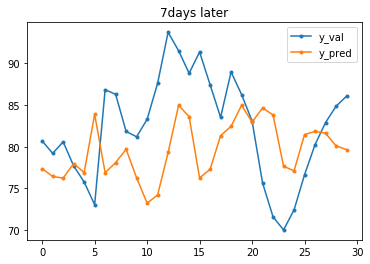

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's l1: 5.74355


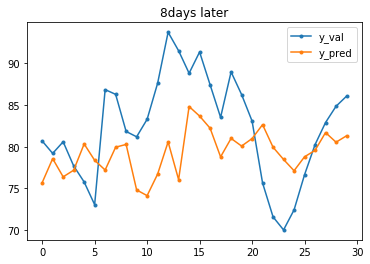

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's l1: 6.49849


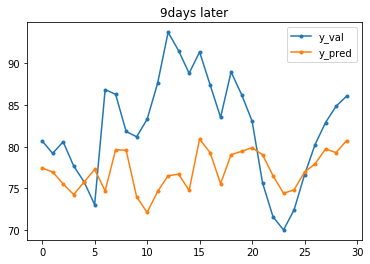

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 5.52351


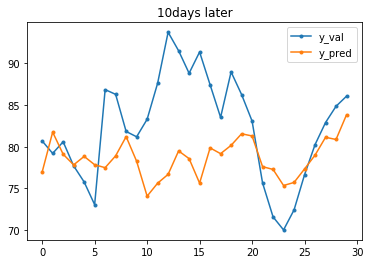

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 6.49415


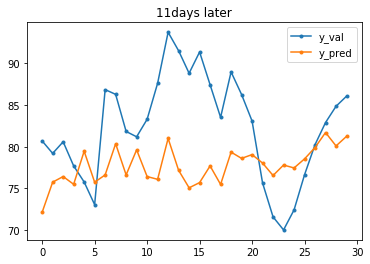

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 6.42725


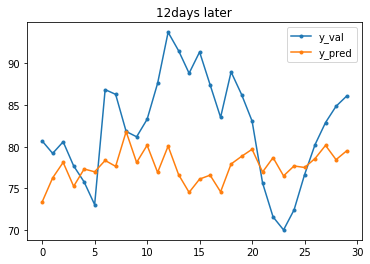

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's l1: 7.82


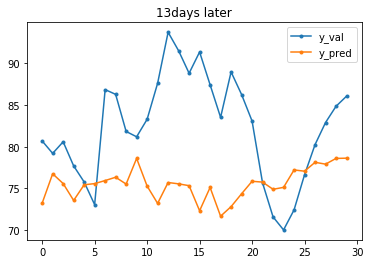

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 7.17458


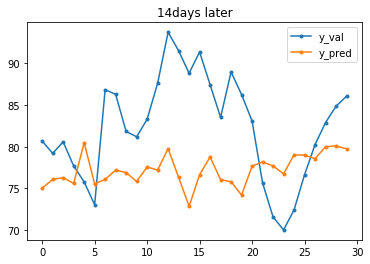

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[112]	valid_0's l1: 6.53027


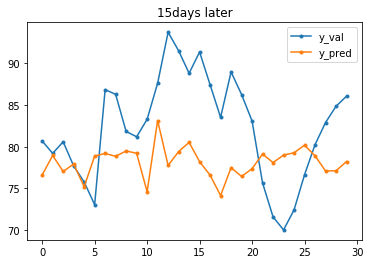

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	valid_0's l1: 6.23752


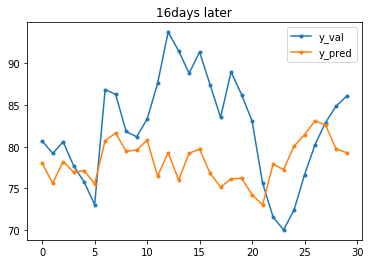

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's l1: 6.11276


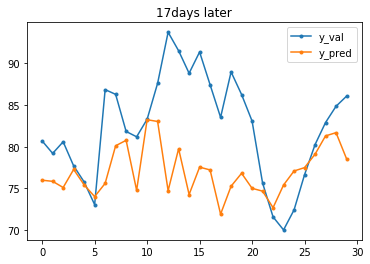

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 6.13234


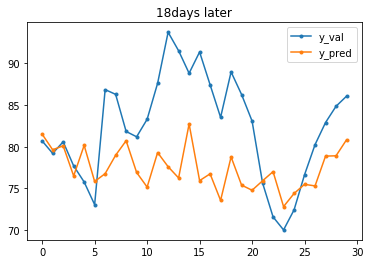

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 6.46257


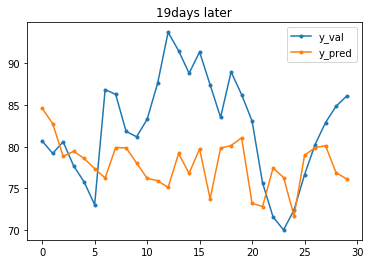

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's l1: 5.08973


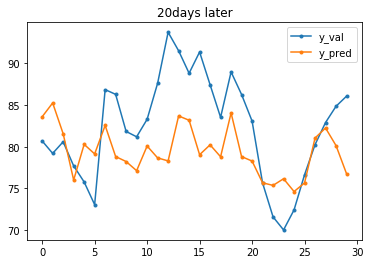

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[626]	valid_0's l1: 5.72928


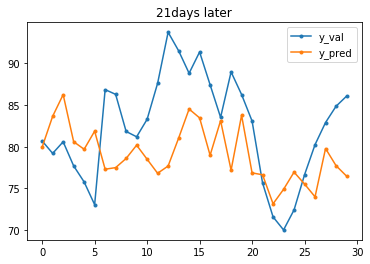

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	valid_0's l1: 5.39898


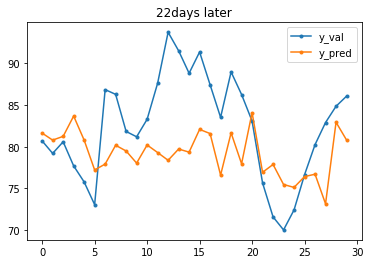

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	valid_0's l1: 5.99827


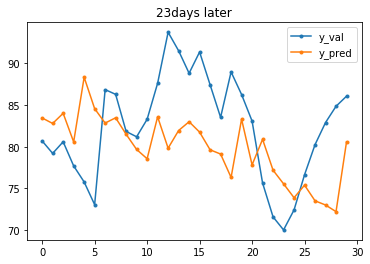

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's l1: 6.2481


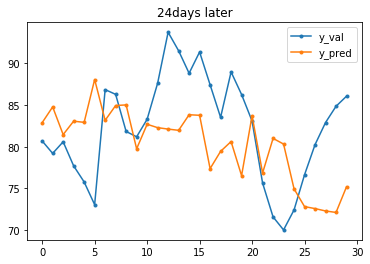

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 6.61707


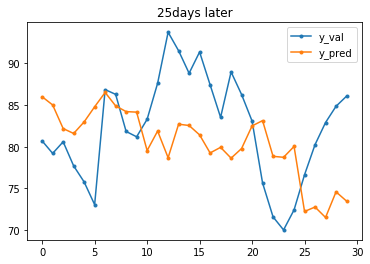

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 4.7914


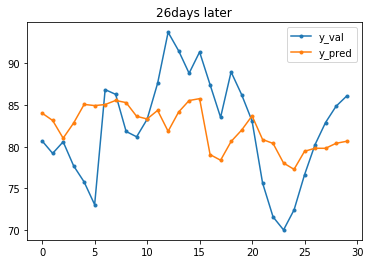

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 4.80792


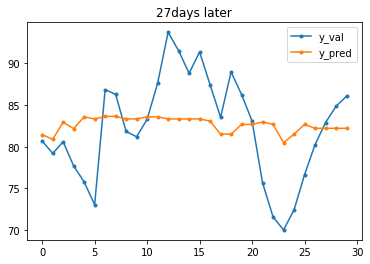

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[14]	valid_0's l1: 4.70901


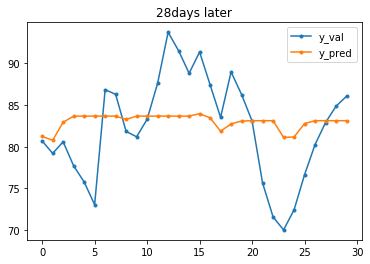

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 4.4486


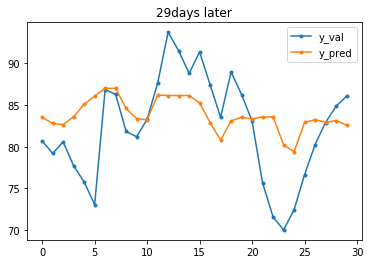

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 4.67381


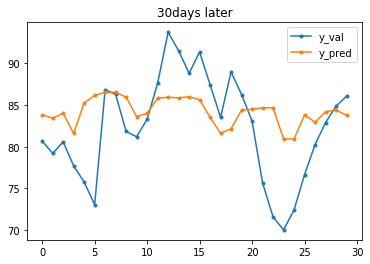

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	valid_0's l1: 4.70333


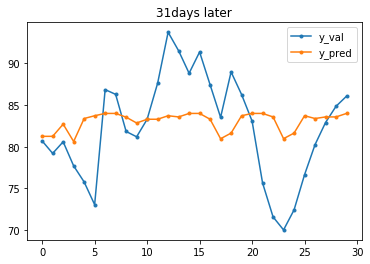

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 4.73397


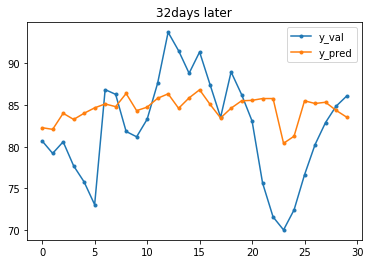

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 4.48779


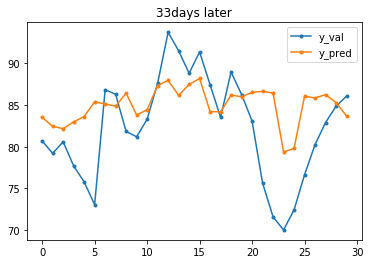

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 4.32747


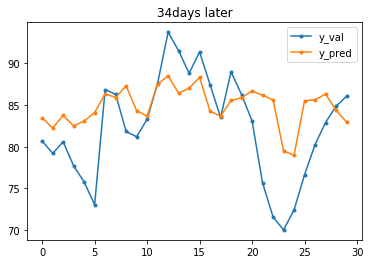

In [42]:
x_columns = ['year','month','day','dayofweek','supply', 'holidays','temp_max', 'temp_min', 'temp_mean','oil_price']
y_columns = ['supply']
supply_models = {}

# 7일~ 34일 후를 예측하는 각각의 모델 구축
for future in range(7,35):
    train_split = target.shape[0]-past-future-30 #마지막 30일은 validation set
    x_train, y_train = trans(target,0,train_split,past,future,x_columns,y_columns)
    x_val, y_val = trans(target,train_split,None,past,future,x_columns,y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)
    
    supply_models[future] = create_model(d_train, d_val)
    print('============================================================')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.95349


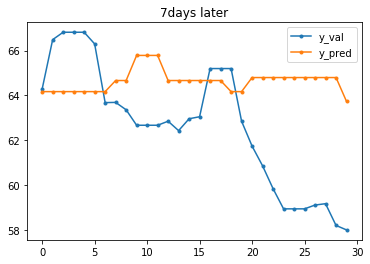

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 2.84123


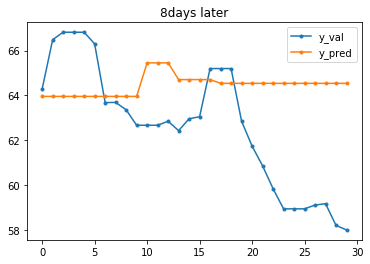

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 2.79384


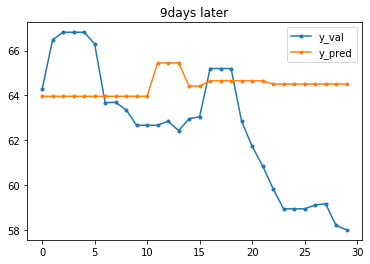

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.78334


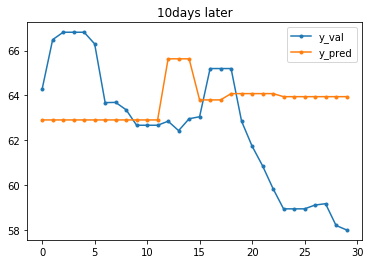

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.5946


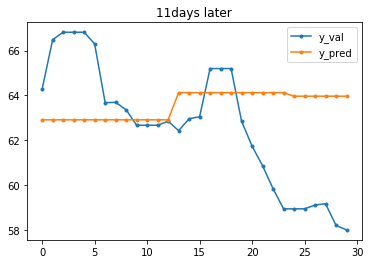

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.62444


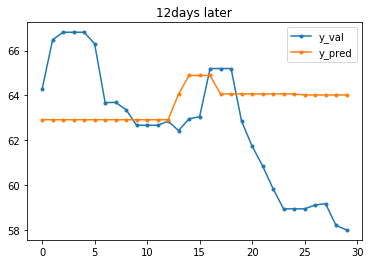

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.55386


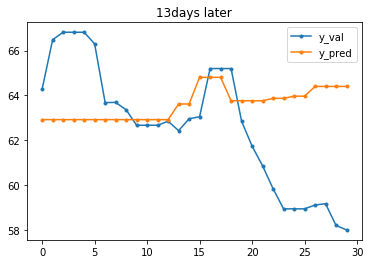

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.62814


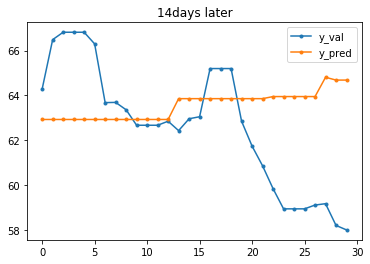

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.56358


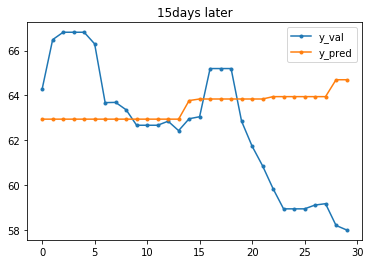

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.4943


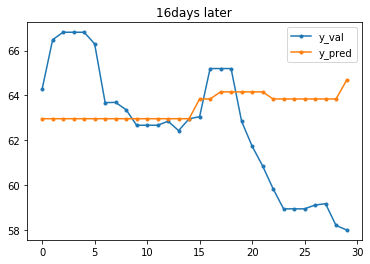

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.45741


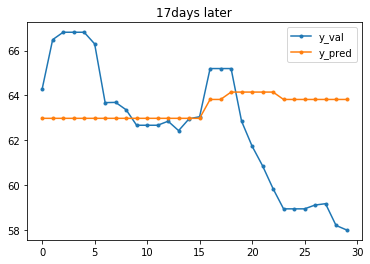

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.42943


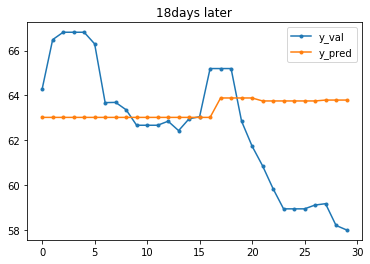

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.50981


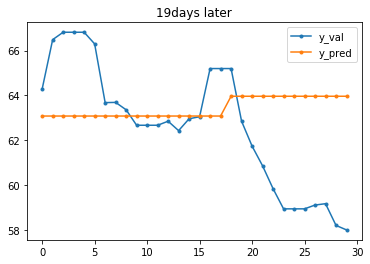

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.36998


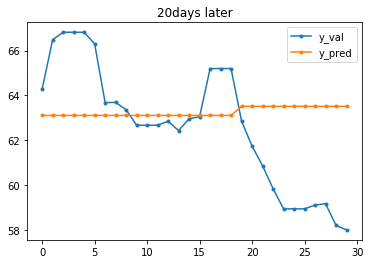

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.21728


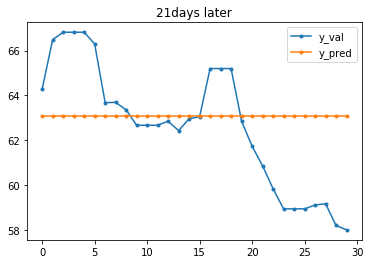

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.21928


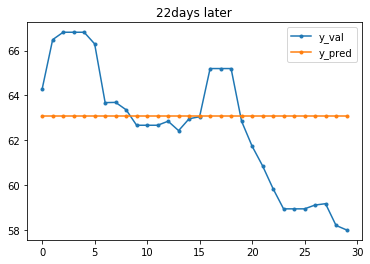

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.21602


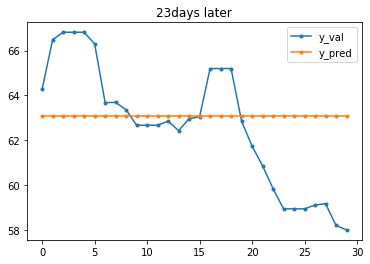

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 2.2177


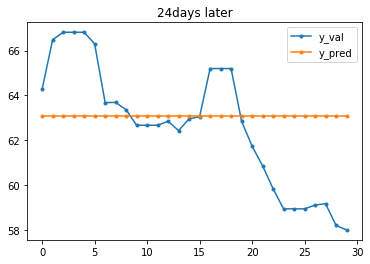

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 2.39063


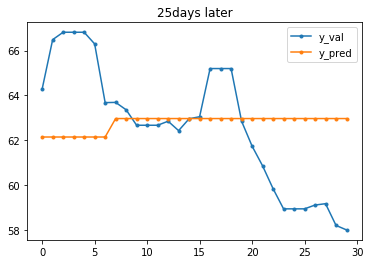

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 2.39171


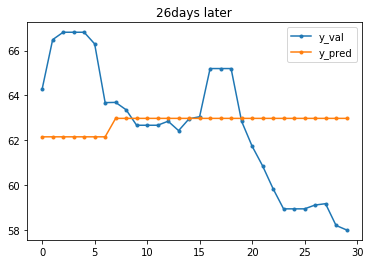

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 2.40354


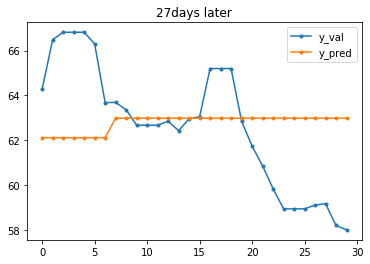

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 2.40522


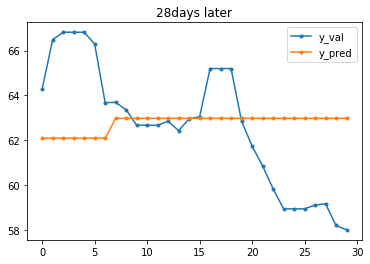

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 2.41095


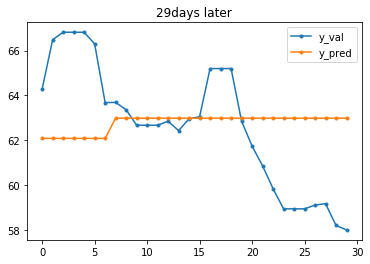

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 2.41878


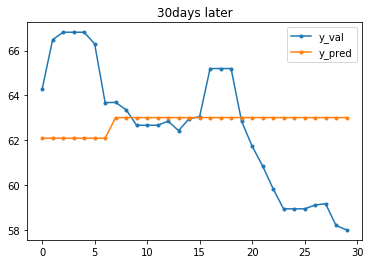

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 2.4199


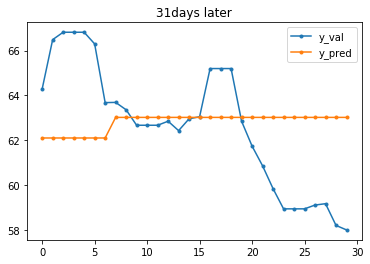

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 2.24436


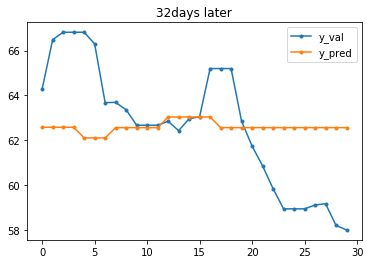

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 2.07088


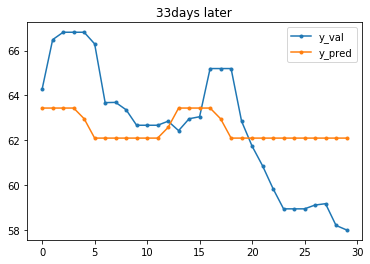

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 2.08824


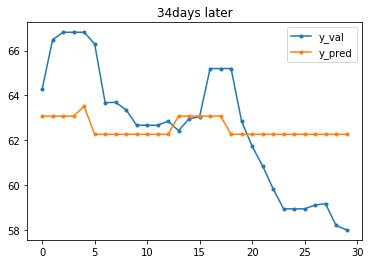

In [47]:
x_columns = ['year','month','day','dayofweek','supply', 'holidays','temp_max', 'temp_min', 'temp_mean','oil_price']
y_columns = ['oil_price']
oil_price_models = {}

# 7일~ 34일 후를 예측하는 각각의 모델 구축
for future in range(7,35):
    train_split = target.shape[0]-past-future-30 #마지막 30일은 validation set
    x_train, y_train = trans(target,0,train_split,past,future,x_columns,y_columns)
    x_val, y_val = trans(target,train_split,None,past,future,x_columns,y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)
    
    oil_price_models[future] = create_model(d_train, d_val)
    print('============================================================')

In [48]:
x_columns = ['year','month','day','temp_max','temp_min','temp_mean']

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 2.2656


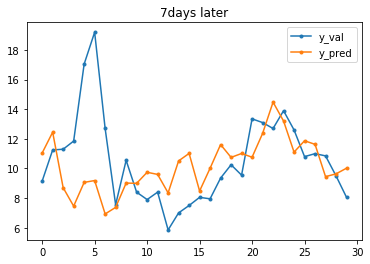

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[33]	valid_0's l1: 1.9365


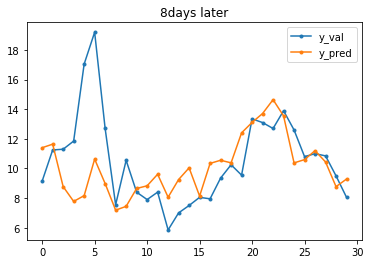

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.98513


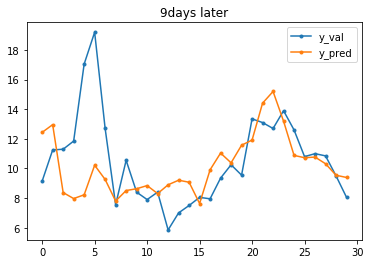

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 1.97005


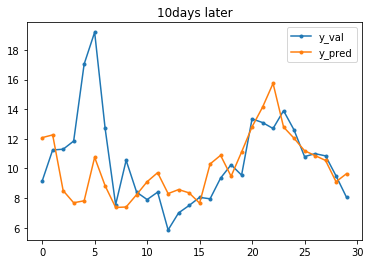

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 2.06566


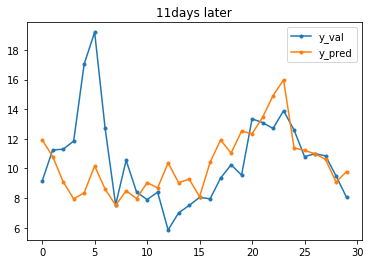

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 2.10043


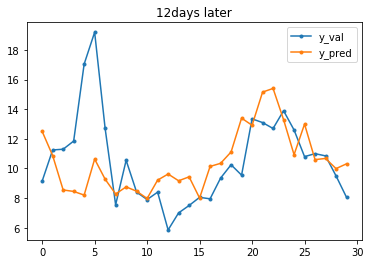

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.97994


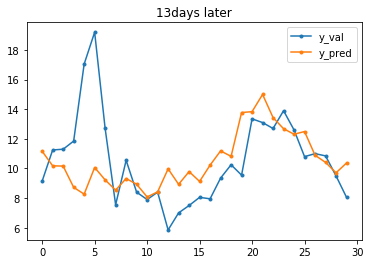

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	valid_0's l1: 1.97759


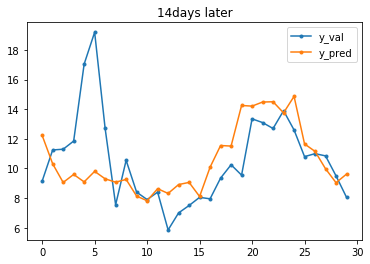

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 1.84972


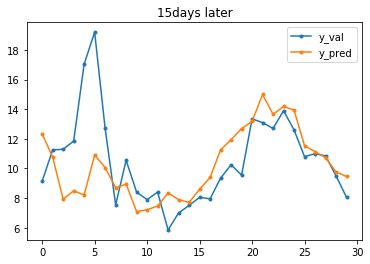

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's l1: 2.01342


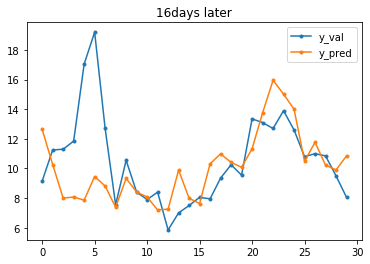

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's l1: 1.84009


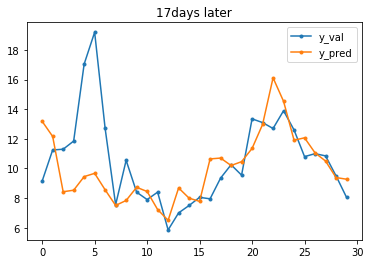

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 1.92511


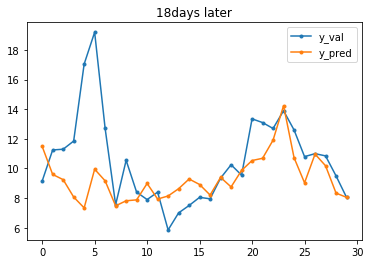

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 1.96938


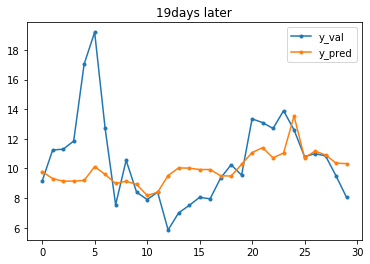

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 2.14502


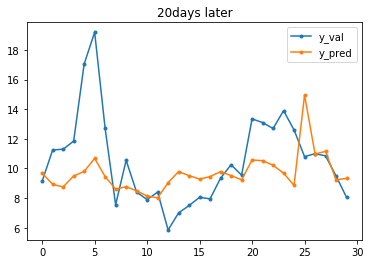

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 2.14924


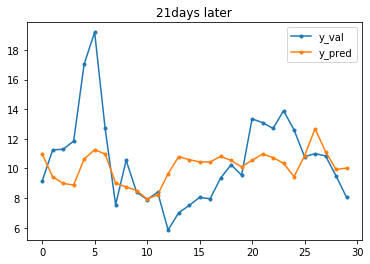

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 2.39929


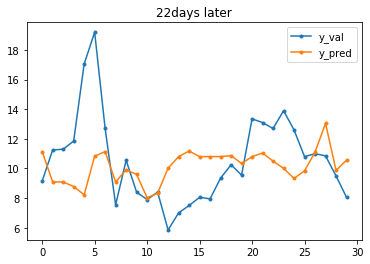

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 2.52156


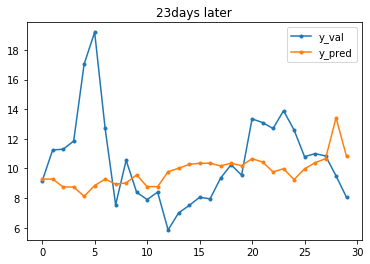

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 2.44333


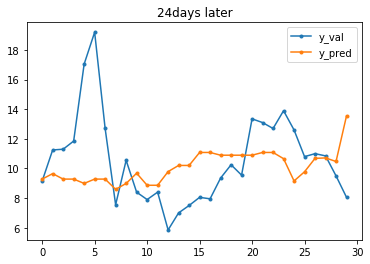

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 2.36668


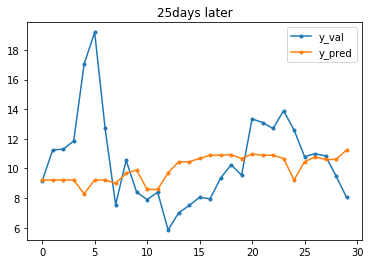

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 2.39097


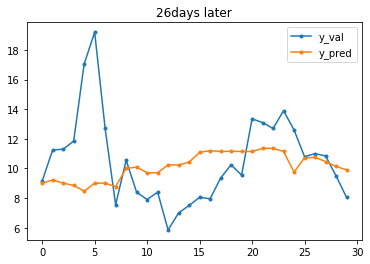

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 2.45478


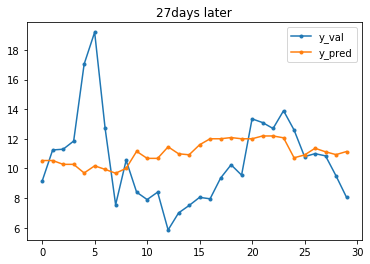

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 2.2994


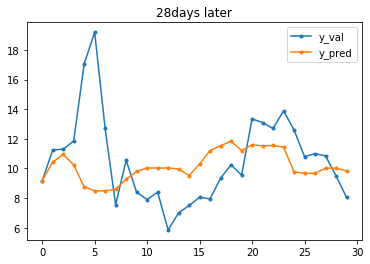

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 2.31


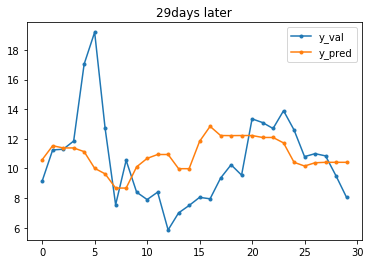

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 2.28444


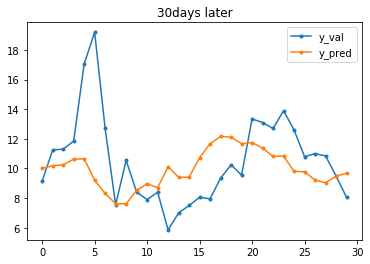

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 2.14625


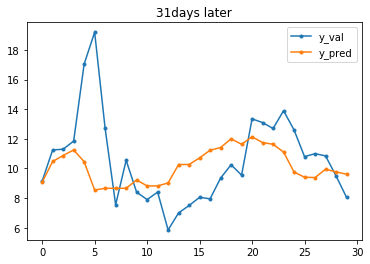

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 2.25647


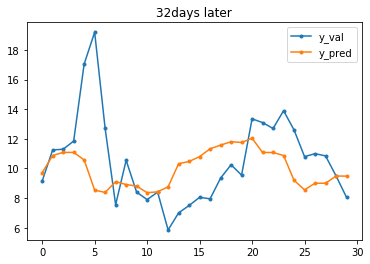

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 2.0517


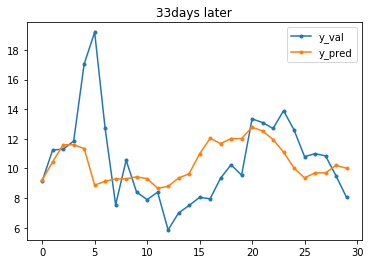

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 2.12849


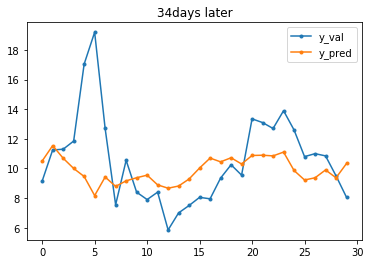

In [49]:
y_columns = ['temp_max']
temp_max_models = {}

for future in range(7,35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)
    
    temp_max_models[future] = create_model(d_train, d_val)
    print('=============================================================')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 1.32124


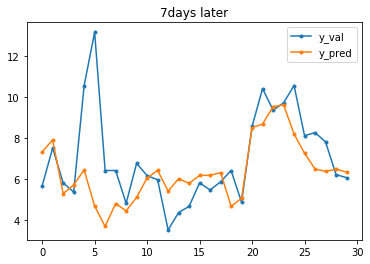

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.24868


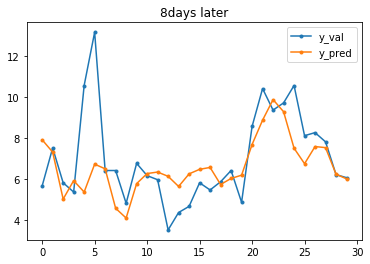

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.31914


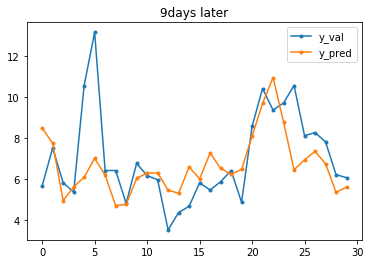

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.4274


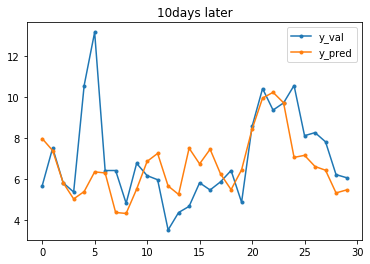

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.3574


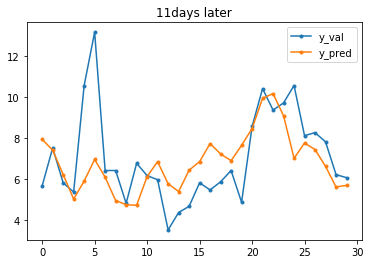

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.22345


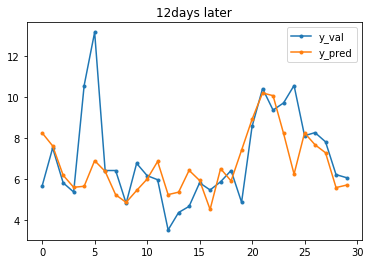

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.27517


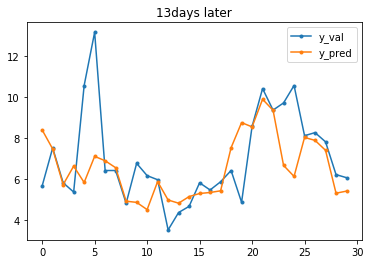

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.22959


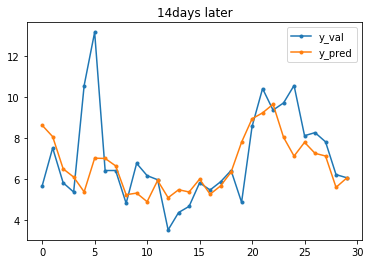

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.27171


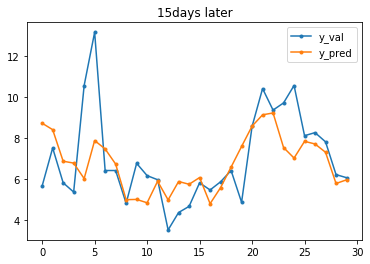

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.24011


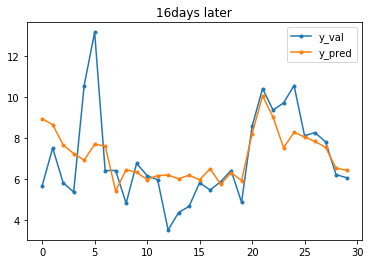

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.49064


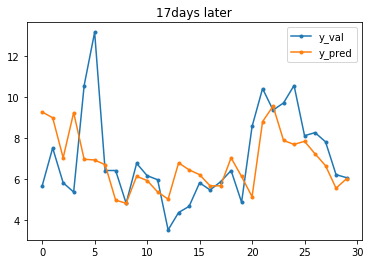

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.51356


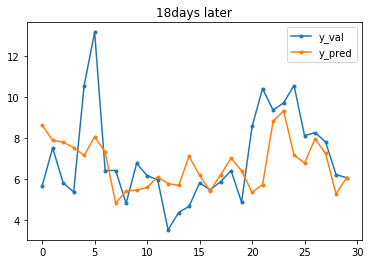

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.63149


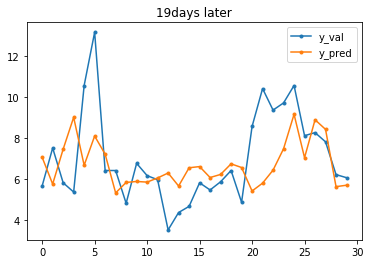

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.6464


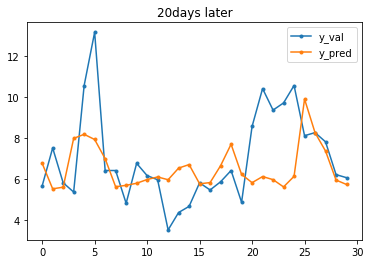

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 1.73824


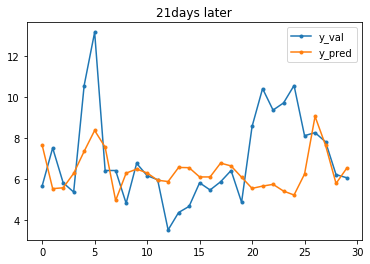

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 1.78632


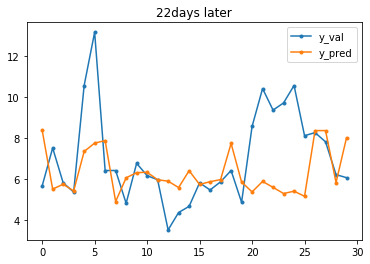

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 2.10204


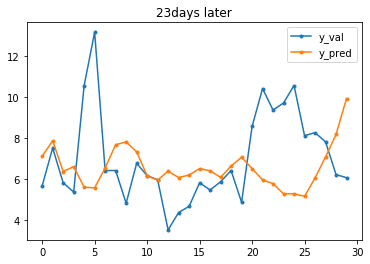

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 2.11963


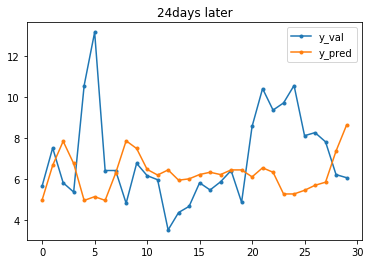

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 1.89623


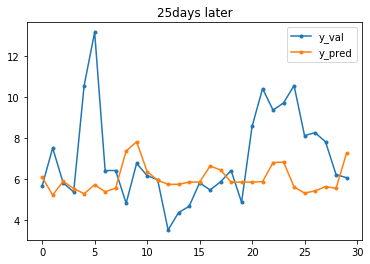

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.78263


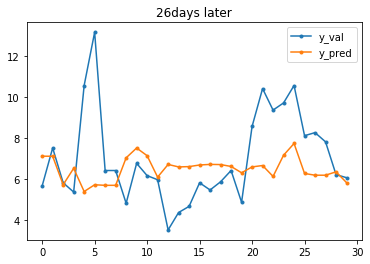

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.74493


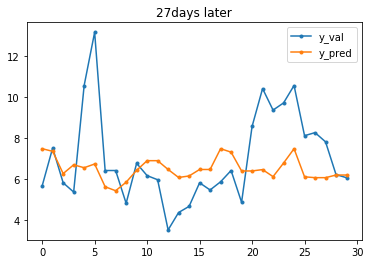

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.72775


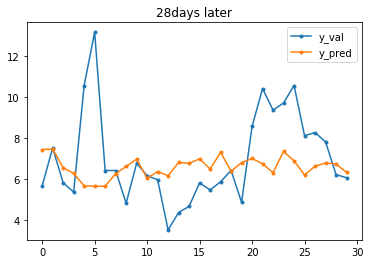

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.71469


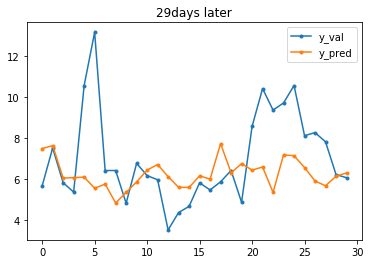

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.82661


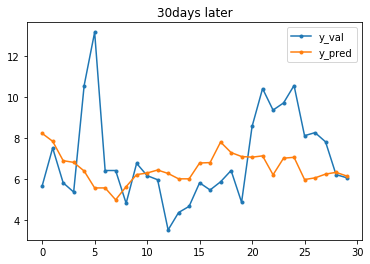

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 1.90355


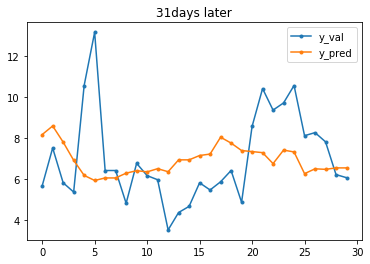

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.83753


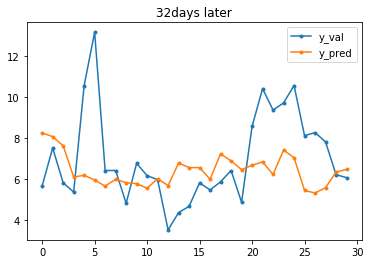

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.72307


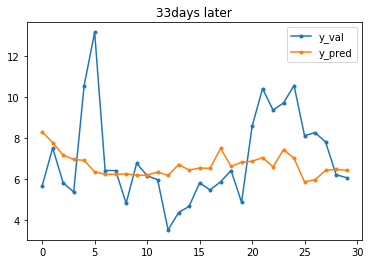

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.64824


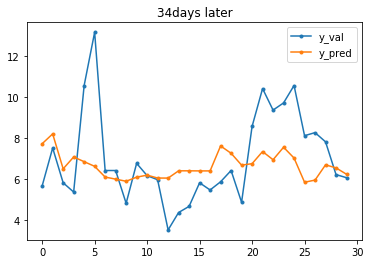

In [50]:
y_columns = ['temp_min']
temp_min_models = {}

for future in range(7,35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target,0,train_split,past,future, x_columns, y_columns)
    x_val, y_val = trans(target,train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)
    
    temp_min_models[future] = create_model(d_train, d_val)
    print('==========================================================')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 1.76334


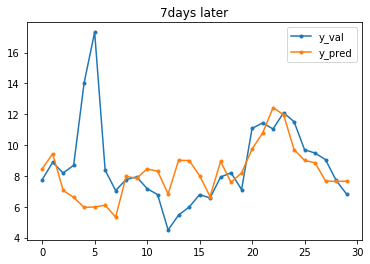

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.6074


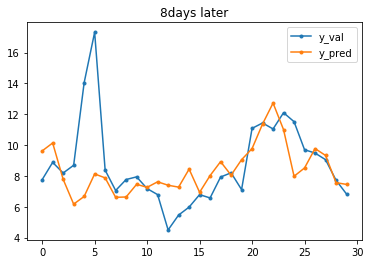

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.56915


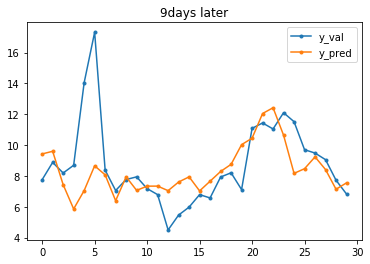

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.65457


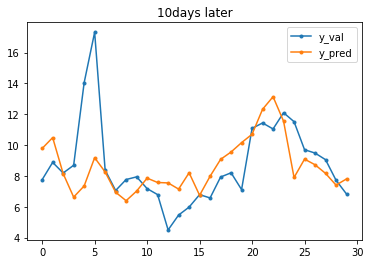

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 1.63424


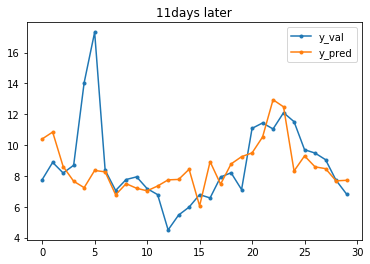

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.68143


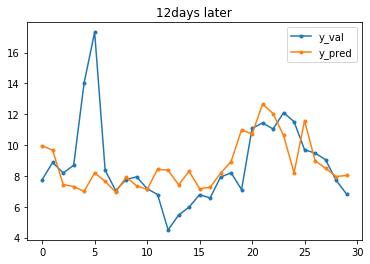

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 1.45982


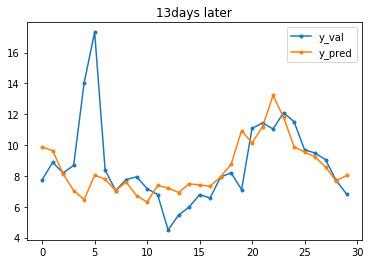

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.40059


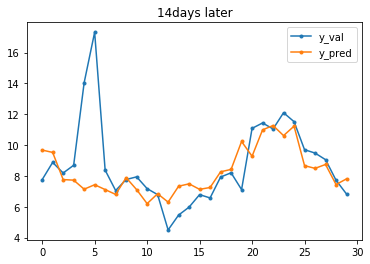

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 1.27975


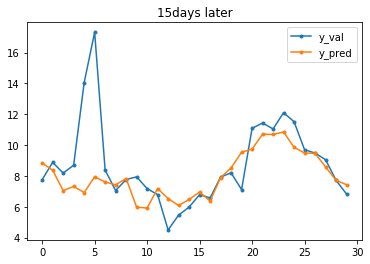

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.38418


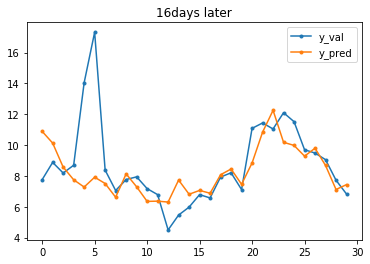

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.41342


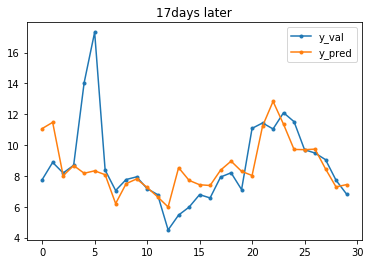

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 1.40546


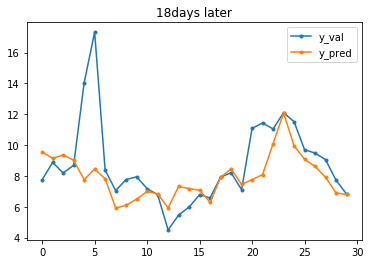

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.63946


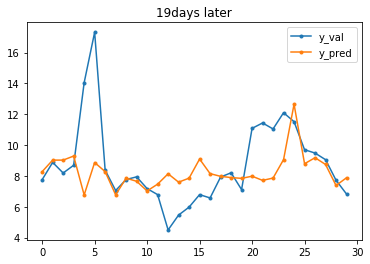

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.68544


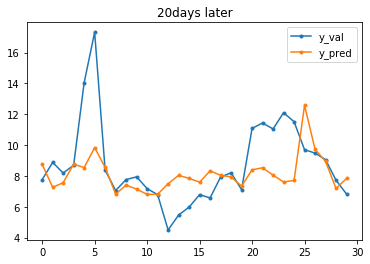

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 1.88333


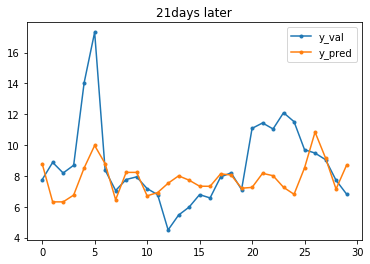

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 2.14123


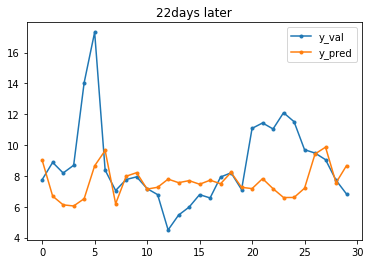

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 2.18272


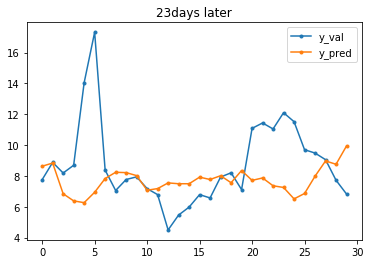

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 2.29059


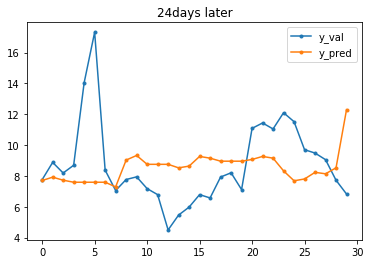

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 2.03627


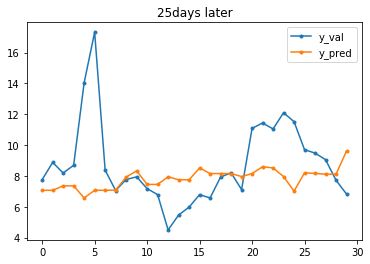

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.92279


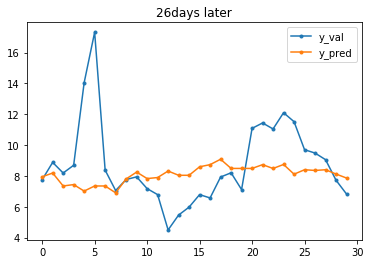

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.98501


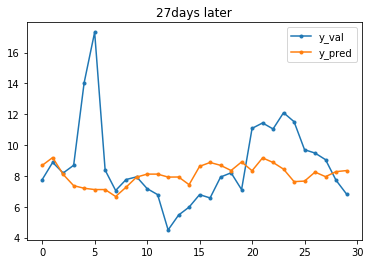

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.9932


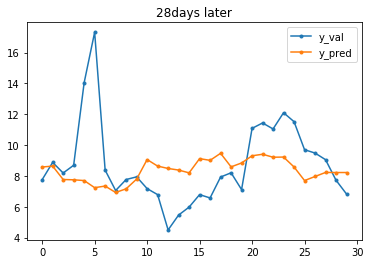

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.95193


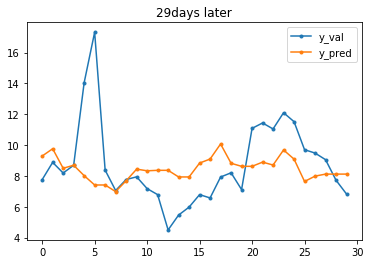

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.9553


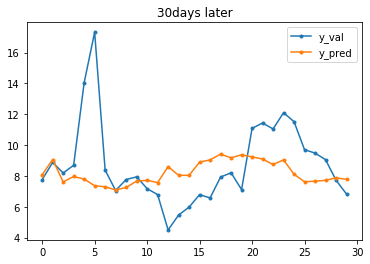

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.89038


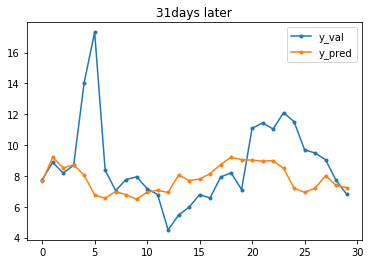

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.97999


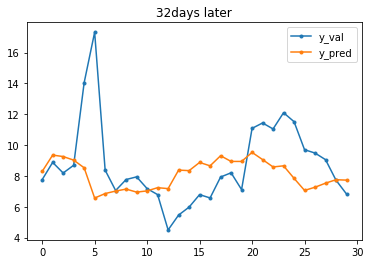

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.84487


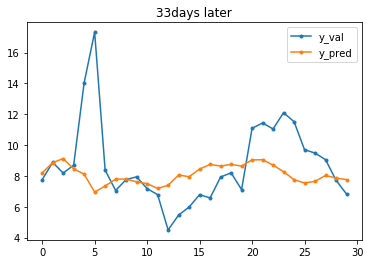

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.75797


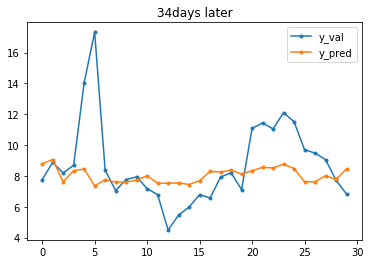

In [51]:
y_columns = ['temp_mean']
temp_mean_models = {}

for future in range(7,35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target,0, train_split, past, future,x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)
    
    temp_mean_models[future] = create_model(d_train, d_val)
    print('=======================================================')

In [56]:
# 총 730개 중에서 validation set 30개 빼고 700부터~
x_test = np.array(target.loc[715:, ['year', 'month', 'day', 'dayofweek', 'supply','holidays', 'temp_max', 'temp_min', 'temp_mean','oil_price']])
# lgb 모델에 넣기 위해서는 한 행으로 만들어야 함
x_test = x_test.reshape(1,-1)

In [57]:
supply_result = []
for future in range(7,35):
    supply_result.append(supply_models[future].predict(x_test))
supply_result = np.array(supply_result).reshape(-1)

In [58]:
oil_price_result = []
for future in range(7,35):
    oil_price_result.append(oil_price_models[future].predict(x_test))
oil_price_result = np.array(oil_price_result).reshape(-1)

In [59]:
x_test = np.array(target.loc[715:, ['year', 'month', 'day', 'temp_max', 'temp_min', 'temp_mean']])
x_test = x_test.reshape(1,-1)

temp_max_result=[]
for future in range(7, 35):
    temp_max_result.append(temp_max_models[future].predict(x_test))
temp_max_result = np.array(temp_max_result).reshape(-1)

In [60]:
temp_min_result=[]
for future in range(7, 35):
    temp_min_result.append(temp_min_models[future].predict(x_test))
temp_min_result = np.array(temp_min_result).reshape(-1)

In [61]:
temp_mean_result=[]
for future in range(7, 35):
    temp_mean_result.append(temp_mean_models[future].predict(x_test))
temp_mean_result = np.array(temp_mean_result).reshape(-1)

In [74]:
submission = pd.read_csv(r'C:\Users\김상휘\Desktop\dacon\sample_submission_v1.csv')

In [76]:
submission = submission.loc[:27,:]
submission_bottom_half = submission.loc[28:,:]
test = submission.copy()
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['dayofweek'] = test['date'].dt.dayofweek
test['supply'] = np.array(supply_result).reshape(-1)
test['oil_price'] = np.array(oil_price_result).reshape(-1)
test['temp_max'] = np.array(temp_max_result).reshape(-1)
test['temp_min'] = np.array(temp_min_result).reshape(-1)
test['temp_mean'] = np.array(temp_mean_result).reshape(-1)

#공휴일 특성
test = pd.merge(test,holidays,on='date',how='left')
names = test.columns.tolist()
names[names.index('name')] = 'holidays'
test.columns = names
test['holidays'].fillna(0, inplace = True)
for i in range(len(test)):
    if test['holidays'][i] !=0:
        test['holidays'][i] = 1

test['holidays'] = test['holidays'].astype(int)
test.head()

date  smp_max  smp_min  smp_mean     supply  year  month  day  \
0 2020-02-07        0        0         0  84.168535  2020      2    7   
1 2020-02-08        0        0         0  81.394303  2020      2    8   
2 2020-02-09        0        0         0  74.315081  2020      2    9   
3 2020-02-10        0        0         0  81.461205  2020      2   10   
4 2020-02-11        0        0         0  81.260241  2020      2   11   

   dayofweek  oil_price   temp_max  temp_min  temp_mean  holidays  
0          4  63.732145  11.579752  5.845921   8.581206         0  
1          5  64.539611  11.085540  5.992161   8.167237         0  
2          6  64.509068  12.036012  7.531734   9.780101         0  
3          0  63.945285  12.835144  7.734639   9.511277         0  
4          1  63.966734  12.145671  7.878674   8.495227         0

#### 예측된 supply와 날씨데이터를 가지고 smp예측하기

In [77]:
def create_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=77)
    
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data.iloc[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data.iloc[val_idx]
        
        d_train = lgb.Dataset(x_train, y_train)
        d_val = lgb.Dataset(x_val, y_val)
        
        params = {
            'metric':'mse',
            'seed':777
        }
        
        model = lgb.train(params, d_train, 1000, d_val, verbose_eval=1000, early_stopping_rounds = 100)
        
        plt.rcParams['figure.figsize'] = [12,4]
        plt.plot(np.array(y_val),'.-',label='y_val')
        plt.plot(model.predict(x_val),'.-',label='y_pred')
        plt.legend()
        plt.show()
        models.append(model)
    
    return models

In [78]:
x_train = target.loc[:,['supply', 'year', 'month', 'day', 'dayofweek', 'holidays','temp_max', 'temp_min', 'temp_mean','oil_price']]
y_train = target.loc[:, ['smp_min', 'smp_max', 'smp_mean' ]]

train column :  smp_min
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	valid_0's l2: 452.23


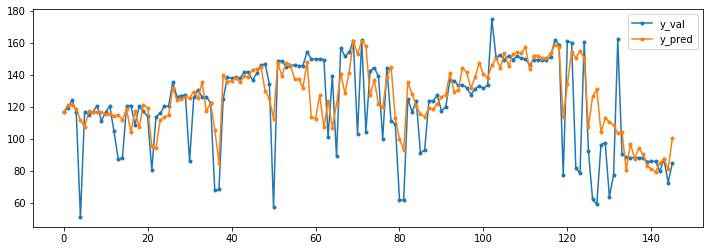

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's l2: 220.623


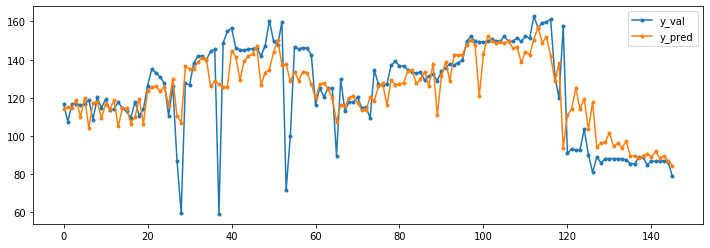

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's l2: 238.485


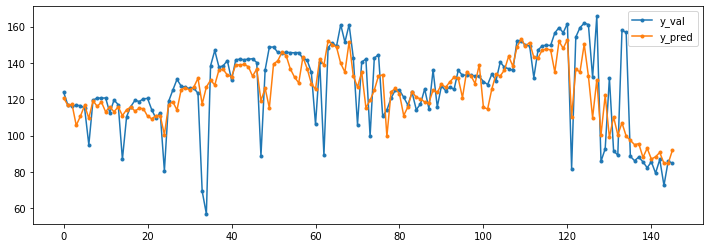

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l2: 148.013


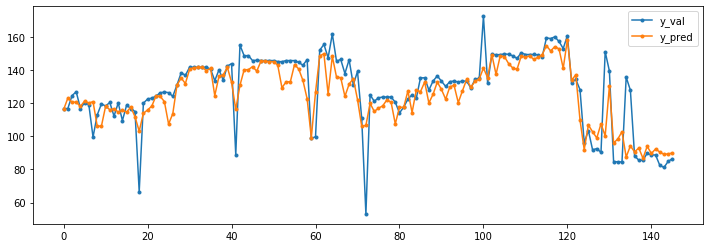

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 157.406


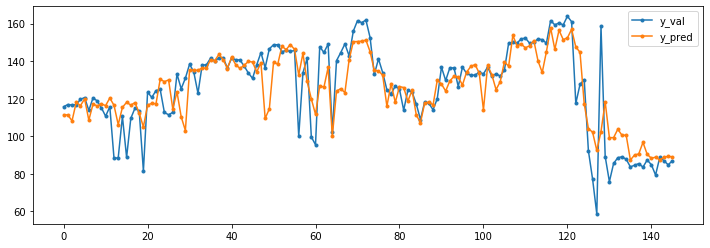

train column :  smp_max
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's l2: 330.546


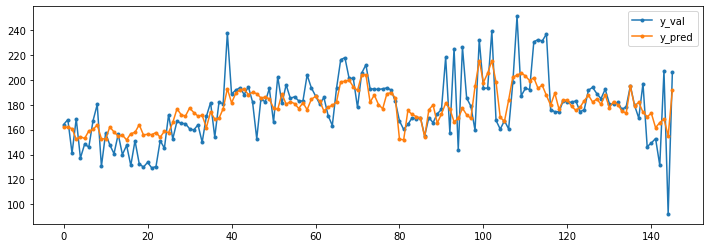

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 292.997


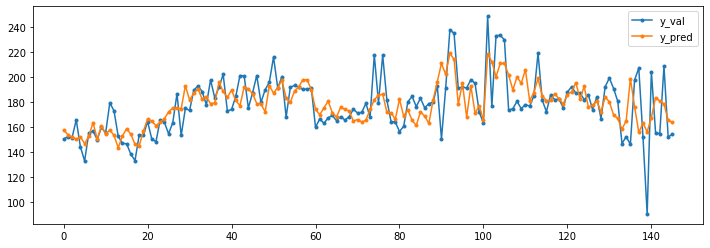

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l2: 230.755


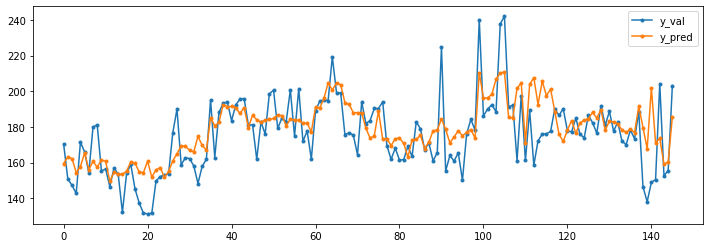

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l2: 1382.91


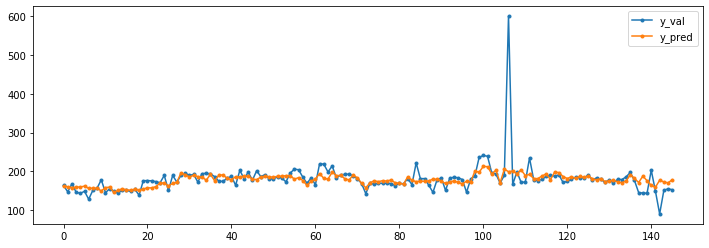

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	valid_0's l2: 757.715


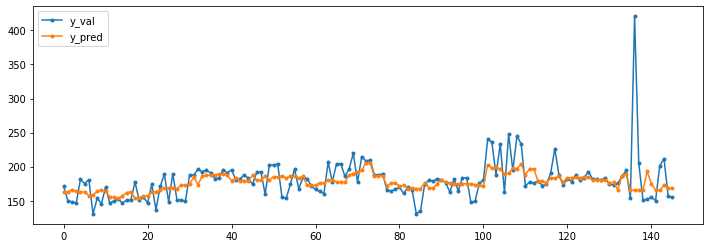

train column :  smp_mean
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	valid_0's l2: 59.9529


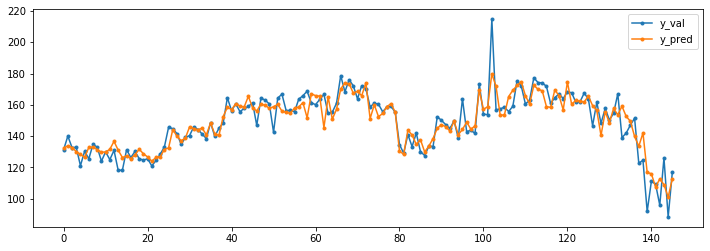

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	valid_0's l2: 56.7371


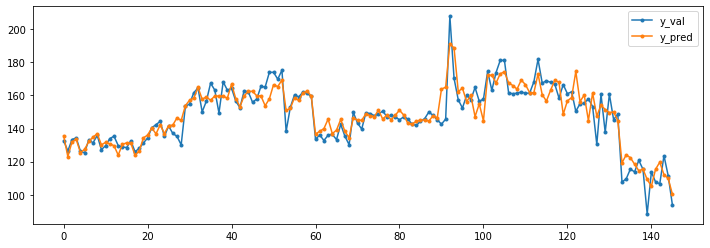

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	valid_0's l2: 55.4035


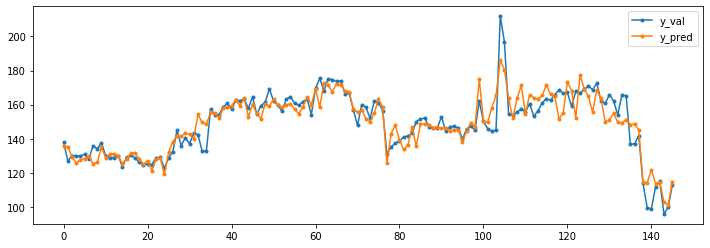

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[195]	valid_0's l2: 66.4489


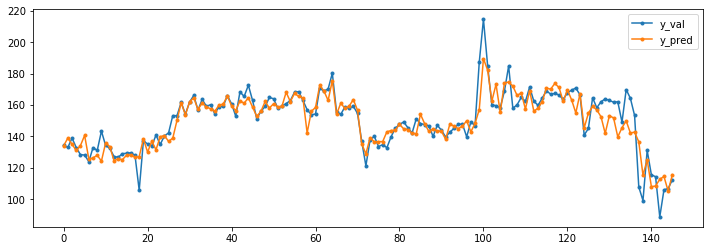

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 56.6533


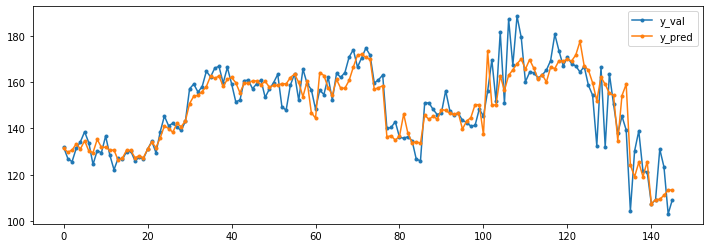

In [79]:
# train과 test를 5개로 나누어서 5번 진행
smp_models = {}
for label in y_train.columns:
    print('train column : ', label)
    smp_models[label] = create_model(x_train, y_train[label])
    print('====================================================')

In [80]:
# 5번 진행된 것을 평균냄
x_test = test.loc[:,['supply', 'year', 'month', 'day', 'dayofweek', 'holidays', 'temp_max', 'temp_min', 'temp_mean','oil_price']]
for label in ['smp_min', 'smp_max', 'smp_mean']:
    preds = []
    for i in range(5):
        preds.append(smp_models[label][i].predict(x_test))
    pred = sum(preds)/len(preds)
    test[label] = pred

In [68]:
submission.reset_index(drop=True, inplace=True)

In [69]:
submission.loc[:, ['smp_min', 'smp_max', 'smp_mean', 'supply']] = test.loc[:,['smp_min', 'smp_max', 'smp_mean', 'supply']]

In [70]:
submission = pd.concat([submission, submission_bottom_half], axis = 0)
submission.reset_index(drop=True, inplace=True)

In [72]:
submission.to_csv('Dacon_baseline.csv', index=False)